The routine, just copy-paste it

In [122]:
import pandas as pd
import numpy as np
import igraph as ig
from scipy.spatial.distance import pdist, squareform
from plotnine import *

def seqs2hamming(seqs, threshold = 1):
    # pairwise hamming
    def hdist(s1, s2):
        if len(s1) != len(s2):
            return float('inf')
        else:
            return sum(c1 != c2 for c1, c2 in zip(s1, s2))
    
    seqs = np.array(seqs).astype("str")
    dm = squareform(pdist(seqs.reshape(-1, 1), metric = lambda x, y: hdist(x[0], y[0])))
    dmf = pd.DataFrame(dm, index=seqs, columns=seqs).stack().reset_index()
    dmf.columns = ['id1','id2','distance']
    dmf = dmf[dmf['distance'] <= threshold]
    
    # graph
    graph = ig.Graph.TupleList(dmf[['id1', 'id2']].itertuples(index=False))
    
    # clusters
    clusters = graph.components()
    membership = clusters.membership
    
    # layout
    layout = graph.layout('graphopt')
    coords = np.array(layout.coords)
    
    df_graph = pd.DataFrame(
        {'cdr3': graph.vs()['name'],
         'cluster': membership,
         'x': coords[:,0],
         'y': coords[:,1]
    })
    
    # summary
    df_graph_summary = df_graph.groupby(['cluster']).agg(
        cluster_size = ('cluster', 'size'), 
        x_mean = ('x', 'mean'), 
        y_mean = ('y', 'mean')).reset_index()
    
    return pd.merge(df_graph, df_graph_summary)

Testing of A*02 GLC

In [123]:
vdjdb = pd.read_csv('vdjdb.slim.txt', sep='\t')

def get_seqs(epi, gene = 'TRB'):
    return vdjdb[(vdjdb['antigen.epitope'] == epi) & (vdjdb['gene'] == gene)]['cdr3']

test_seqs = get_seqs('GLCTLVAML')

res = seqs2hamming(test_seqs)
res

,cdr3,cluster,x,y,cluster_size,x_mean,y_mean
0,CASIPEGGRETQYF,0,-301.451313,-314.259030,1,-301.451313,-314.259030
1,CASSEGRISPGELFF,1,135.129451,67.565574,12,111.170383,90.515444
2,CASSEGRVSPGELFF,1,119.929664,88.846763,12,111.170383,90.515444
3,CASSEGRVLSGELFF,1,103.324800,45.651130,12,111.170383,90.515444
4,CASSEGRVLPGELFF,1,102.953739,69.861562,12,111.170383,90.515444
...,...,...,...,...,...,...,...
971,CAIEGGQSYEQYF,801,72.035140,531.144183,1,72.035140,531.144183
972,CASSVGSNTGELFF,802,57.030601,-803.544736,1,57.030601,-803.544736
973,CASSFGATDTQYF,803,-322.101263,-70.680012,1,-322.101263,-70.680012
974,CASSLSLHGNQPQHF,804,4.101026,372.554783,1,4.101026,372.554783


Write to file and plot

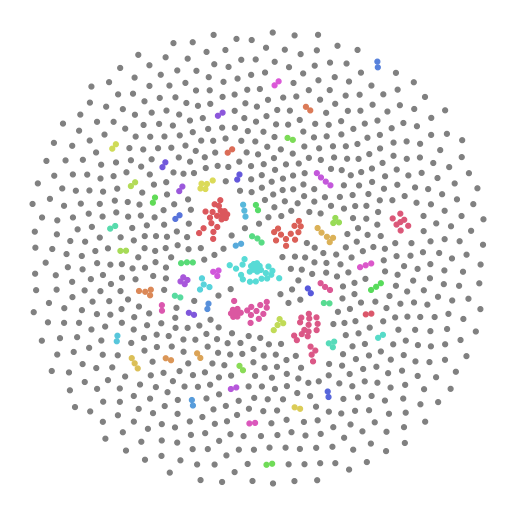

In [124]:
res.to_csv("test_clusters.tsv", sep = "\t", index=False)

res['cc'] = res['cluster'].astype("str")
g = (ggplot(res[res['cluster_size'] > 1], aes(x='x', y='y', color='cc')) + 
     geom_point(data = res[res['cluster_size'] == 1], color = 'grey') +
     geom_point() + 
     scale_color_discrete(guide=False) +
     xlab('') +
     ylab('') +
     theme_void() +
     theme(aspect_ratio = 1))
print(g)

Now run it for groups - select epitopes with 500+ entries

In [125]:
epitopes = test[(test['gene'] == 'TRB') & (test['antigen.epitope'] != 'KLGGALQAK')]
epitopes = epitopes.groupby(['antigen.epitope']).agg(size = ('cdr3', 'size'))
epitopes = list(epitopes[epitopes['size'] >= 500].index)
len(epitopes)

10

Build and concat matrices for all epitopes

In [126]:
def fun2(epi):
    df = seqs2hamming(get_seqs(epi))
    df['group'] = epi
    return df

res2 = pd.concat([fun2(epi) for epi in epitopes])
res2

,cdr3,cluster,x,y,cluster_size,x_mean,y_mean,group
0,CASSVTDRIRNTIYF,0,226.181376,535.269953,1,226.181376,535.269953,AVFDRKSDAK
1,CASSYLLAGLYNEQFF,1,-326.654995,22.099479,1,-326.654995,22.099479,AVFDRKSDAK
2,CASRLSGSAYEQYF,2,-198.920217,912.073105,1,-198.920217,912.073105,AVFDRKSDAK
3,CASSVTSSRGGTDTQYF,3,42.815817,757.878882,1,42.815817,757.878882,AVFDRKSDAK
4,CASSLSFRAHNEQFF,4,390.527926,341.570476,1,390.527926,341.570476,AVFDRKSDAK
...,...,...,...,...,...,...,...,...
681,CSASDRRDEQFF,396,-527.146064,-290.316285,1,-527.146064,-290.316285,YLQPRTFLL
682,CAIADANTGELFF,397,-410.043498,168.059475,1,-410.043498,168.059475,YLQPRTFLL
683,CAGLIMNTGELFF,398,-444.253797,204.848187,1,-444.253797,204.848187,YLQPRTFLL
684,CASSPEDTQYF,399,-336.954207,-529.799192,1,-336.954207,-529.799192,YLQPRTFLL


Plot

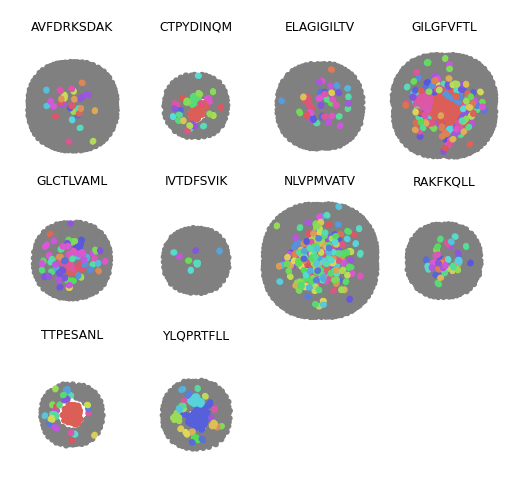

In [127]:
res2['cc'] = res2['cluster'].astype("str")
g2 = (ggplot(res2[res2['cluster_size'] > 1], aes(x='x', y='y', color='cc')) + 
     geom_point(data = res2[res2['cluster_size'] == 1], color = 'grey') +
     geom_point() + 
     scale_color_discrete(guide=False) +
     xlab('') +
     ylab('') +
     facet_wrap('group') +
     theme_void() +
     theme(aspect_ratio = 1))
print(g2)